In [1]:
import os
import re

from datetime import datetime, timedelta
from zoneinfo import ZoneInfo
from time import sleep

from bot.core.exchange.http_api import ExchangeManager, BybitRestAPI
from bot.utils.files import load_tokens_from_file
from bot.utils.coinmarketcap import get_top_tokens
from bot.core.db.postgres_manager import DBManager
from bot.config.credentials import host, user, password, db_name
from bot.utils.pair_trading import create_zscore_df, round_down, get_lr_zscore, get_dist_zscore, get_tls_zscore

db_params = {'host': host, 'user': user, 'password': password, 'dbname': db_name}
db_manager = DBManager(db_params)

import pandas as pd
# pd.options.display.float_format = '{:.2f}'.format

import polars as pl
import polars_ols as pls

import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from itertools import combinations

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings("ignore")

from tqdm.notebook import tqdm

In [2]:
def sort_pairs(df: pl.DataFrame) -> pl.DataFrame:
    return df.with_columns([
        pl.when(pl.col("coin1") <= pl.col("coin2")).then(pl.col("coin1")).otherwise(pl.col("coin2")).alias("pair_min"),
        pl.when(pl.col("coin1") <= pl.col("coin2")).then(pl.col("coin2")).otherwise(pl.col("coin1")).alias("pair_max"),
    ]).drop('coin1', 'coin2').rename({'pair_min': 'coin1', 'pair_max': 'coin2'}).select('coin1', 'coin2', pl.exclude('coin1', 'coin2'))

In [3]:
# get_top_tokens(limit=1000, output_file='./bot/config/top_1000_tokens.txt')

#### Скачиваем данные с Bybit

In [4]:
async def get_data(symbol, interval, n_iters):
    df = await exc_manager.get_candles(symbol=symbol, interval=interval, n_iters=n_iters)
    df = df['bybit_linear'].sort_index()
    df['Returns'] = df['Close'].pct_change()
    df['Log_price'] = np.log(df['Close'] + 1)
    df['Log_returns'] = np.log(df['Close']/df['Close'].shift(1))
    return df.dropna()

In [5]:
exc_manager = ExchangeManager()
exc_manager.add_market("bybit_linear", BybitRestAPI('linear'))

In [6]:
res = await get_data(symbol='ADA_USDT', interval='1h', n_iters=1)
res.shape

(999, 11)

In [7]:
top_1000_tokens = load_tokens_from_file("./data/top_1000_tokens.txt")
tokens_to_del = ['USDT', 'USDC', 'LEO', 'USDe']
prices = await exc_manager.get_prices()
prices = prices['bybit_linear']

token_list = [x + '_USDT' for x in top_1000_tokens if x not in tokens_to_del]
token_list = [col for col in token_list if col in prices.keys()]
len(token_list)

493

In [8]:
with open('./bot/config/tokens.txt', 'r') as file:
    current_tokens = [line.strip() for line in file.readlines()]
len(current_tokens)

80

In [9]:
all_ = db_manager.get_orderbooks()
all_tokens = all_['token'].unique().to_list()

In [10]:
# Отбираем только те токены, которые есть в БД с ордербуками
token_list = []

for token in sorted(all_tokens):
    first_date = db_manager.get_oldest_date_in_orderbook(token)
    
    if first_date < datetime(2025, 12, 3, 0, tzinfo=ZoneInfo("Europe/Moscow")):
        token_list.append(token)

token_list.extend(['BTC_USDT', 'ETH_USDT', 'SOL_USDT'])
len(token_list)

77

In [11]:
# Настройки параметров
interval = '1d'
n_iters = 1
start_date = datetime(2025, 5, 20, tzinfo=ZoneInfo("Europe/Moscow"))
end_date = datetime(2025, 12, 3, tzinfo=ZoneInfo("Europe/Moscow"))
min_volume = 2_000_000
days_ago = 30 # За сколько последних дней смотреть волатильность
max_volatility = 45
max_price = 30

bad_tokens = []
good_tokens = []

In [12]:
main_df = pd.DataFrame()

for token in tqdm(token_list):
    sleep(0.5)
    df = await get_data(symbol=token, interval=interval, n_iters=n_iters)
    df = df.reset_index()

    if df.empty:
        continue
    
    first_date = df['Date'].head(1).item().floor('D')
    last_date = df['Date'].tail(1).item().floor('D')
    
    if first_date > pd.Timestamp('2025-06-10', tz='Europe/Moscow'):
        continue
    if last_date < pd.Timestamp('2025-11-10', tz='Europe/Moscow'):
        continue

    vol_mean = df[-11: -1]['Turnover'].mean()
    vol24 = df.iloc[-2]['Turnover']
    if vol24 < min_volume and vol_mean < min_volume:
        if token in current_tokens:
            print(f'{token} недостаточно торгового объёма (10d_avg: {int(vol_mean):_} / last_24h: {int(vol24):_})')
            bad_tokens.append(token)
        continue
    
    df = df[(df['Date'] > start_date) & (df['Date'] < end_date)]
    df = df.set_index('Date')
    daily_df = df[-days_ago:]
    daily_df['Max_range'] = daily_df['High'] - daily_df['Low']
    daily_df['Max_range_perc'] = (daily_df['High'] - daily_df['Low']) / daily_df['Low'] * 100

    if daily_df['Max_range_perc'].max() > max_volatility:
        if token in current_tokens:
            print(f'{token} высокая волатильность: {daily_df['Max_range_perc'].max():.1f}%')
            bad_tokens.append(token)
        continue

    if daily_df['Close'][-1] > max_price and token not in ('BTC_USDT', 'ETH_USDT', 'SOL_USDT'):
        continue

    main_df[f'{token[:-5]}_price'] = df['Close']
    main_df[f'{token[:-5]}_returns'] = df['Returns']
    main_df[f'{token[:-5]}_log_returns'] = df['Log_returns']
    main_df[f'{token[:-5]}_log_price'] = df['Log_price']
    good_tokens.append(token)

  0%|          | 0/77 [00:00<?, ?it/s]

BRETT_USDT высокая волатильность: 45.6%
MANA_USDT недостаточно торгового объёма (10d_avg: 1_590_512 / last_24h: 1_455_139)
MANTA_USDT недостаточно торгового объёма (10d_avg: 1_447_096 / last_24h: 811_223)
MOVE_USDT недостаточно торгового объёма (10d_avg: 1_792_595 / last_24h: 1_171_111)
ORDI_USDT высокая волатильность: 48.4%
RENDER_USDT высокая волатильность: 51.1%
STRK_USDT высокая волатильность: 51.5%
SUSHI_USDT недостаточно торгового объёма (10d_avg: 1_514_493 / last_24h: 968_020)
TIA_USDT высокая волатильность: 46.8%
VET_USDT недостаточно торгового объёма (10d_avg: 1_481_481 / last_24h: 1_365_086)


In [ ]:
# ROSE_USDT недостаточно торгового объёма (10d_avg: 1_015_712 / last_24h: 338_698)

In [13]:
main_df.shape

(197, 268)

In [14]:
len(current_tokens), len(bad_tokens), len(good_tokens)

(80, 10, 67)

In [15]:
[current_tokens.remove(token) for token in bad_tokens]
len(current_tokens)

70

In [16]:
good_tokens = sorted(list(set(good_tokens)))
len(good_tokens)

67

#### Distance approach

In [17]:
from bot.utils.data import make_price_df_from_orderbooks_bulk, normalize
import itertools
import math

In [18]:
exc_manager = ExchangeManager()
exc_manager.add_market("bybit_linear", BybitRestAPI('linear'))
coin_information = exc_manager.get_instrument_data()

In [19]:
# Создадим список из датафреймов для удобства пакетной обработки, а также получим кол-во знаков после запятой для округления
max_days = 180 # За сколько дней считать расстояние
tokens = [x[:-5] for x in sorted(good_tokens)]
dfs = []
token_std = {}
token_dist = {}

for token in tokens:
    try:
        df_token = main_df[[f'{token}_price']].rename(columns={f'{token}_price': 'price'})
        df_token['token'] = token
        df_token = pl.from_pandas(df_token, include_index=True).rename({'Date': 'time'}).tail(max_days)
    except KeyError:
        print(token)
        continue
    
    token_std[token] = main_df[[f'{token}_returns']].std()
    token_dist[token] = df_token['price'].max() - df_token['price'].min()
    dfs.append(df_token)

In [20]:
price_df = make_price_df_from_orderbooks_bulk(dfs=dfs, tokens=tokens, trunc='5m')
curr_prices = price_df.drop('time').tail(1).transpose(include_header=True, header_name='coin', column_names=['price'])
price_df.tail(1)

time,1INCH,ADA,AERO,ALGO,APT,ARB,ARKM,ATOM,AVAX,BTC,CELO,CRV,DOGE,DOT,DRIFT,DYDX,EGLD,EIGEN,ENA,ENS,ETC,ETHFI,ETH,FARTCOIN,FLOW,GALA,GLM,GMT,GRT,HBAR,IMX,INJ,IP,JASMY,JTO,JUP,KAS,LDO,MNT,MORPHO,NEAR,NXPC,OM,ONDO,OP,PENDLE,PNUT,POL,RUNE,SAND,SEI,SOL,SPX,STX,SUI,S,THETA,TON,TRX,TWT,WCT,WIF,WLD,XLM,XRP,XTZ,ZRO
"datetime[ns, Europe/Moscow]",f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-12-02 03:00:00 MSK,0.2032,0.4334,0.6573,0.1386,1.968,0.2125,0.2327,2.362,13.623,91241.7,0.167,0.3868,0.14569,2.2478,0.2288,0.2293,7.44,0.5623,0.2696,11.585,13.577,0.8425,2994.84,0.3523,0.2261,0.00741,0.22821,0.01731,0.04916,0.14462,0.3053,5.825,2.3157,0.007292,0.4662,0.2472,0.05443,0.6158,1.0243,1.4614,1.803,0.4522,0.07526,0.5011,0.3166,2.641,0.08822,0.1294,0.6582,0.151,0.1377,138.64,0.6986,0.3074,1.6274,0.1031,0.3399,1.5784,0.28071,1.0078,0.09289,0.4044,0.6278,0.25457,2.1525,0.4848,1.4285


In [21]:
price_df.shape, price_df.drop_nans().shape

((180, 68), (180, 68))

In [22]:
normed_df = normalize(df=price_df, method='minimax', shift_to_zero=False)

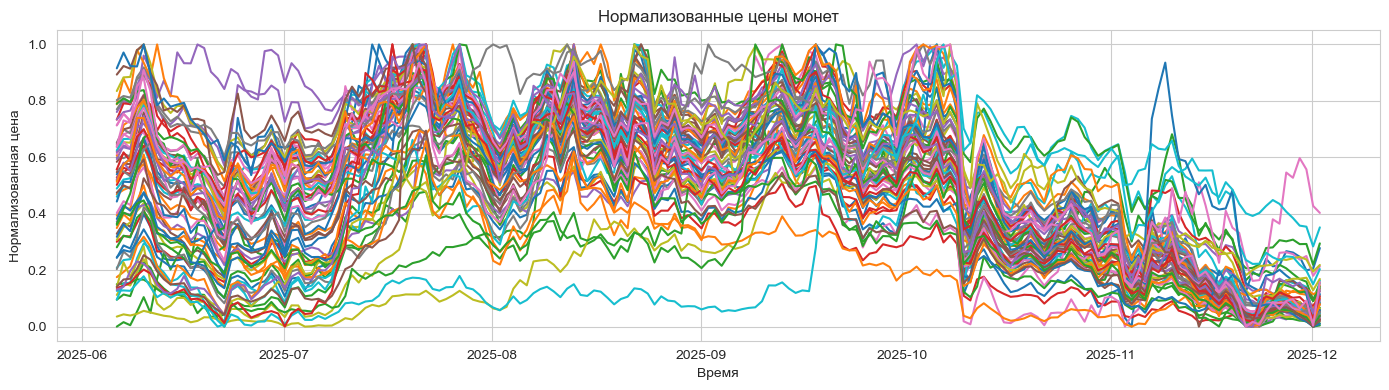

In [23]:
# Нарисуем график с нормализованными ценами
price_cols = [c for c in normed_df.columns if c != 'time']

plt.figure(figsize=(14, 4))
for col in price_cols:
    plt.plot(normed_df['time'].to_list(), normed_df[col].to_list(), label=col)

plt.xlabel("Время")
plt.ylabel("Нормализованная цена")
plt.title("Нормализованные цены монет")
plt.grid(True)
plt.tight_layout()

In [24]:
# Посчитаем евклидово расстояние между парами криптовалют
results = []

# Перебираем все уникальные пары колонок
for col1, col2 in itertools.combinations(price_cols, 2):
    diff_sq = (normed_df[col1] - normed_df[col2]) ** 2
    distance = math.sqrt(diff_sq.sum())
    std = np.std((normed_df[col1] - normed_df[col2]).to_numpy())
    results.append((col1, col2, distance, std))

In [25]:
std_df = pl.DataFrame({"token": list(token_std.keys()), "std_value": list(token_std.values())})
max_dist_df = pl.DataFrame({"token": list(token_dist.keys()), "max_dist": list(token_dist.values())})

In [26]:
dist_df = pl.DataFrame(results, schema=["coin1", "coin2", "dist", "std"], orient="row").sort('dist')
dist_df = dist_df.join(curr_prices, left_on='coin1', right_on='coin').rename({'price': 'price1'})
dist_df = dist_df.join(curr_prices, left_on='coin2', right_on='coin').rename({'price': 'price2'})
dist_df = dist_df.filter(
    (pl.col('price1') / pl.col('price2') < 5) & (pl.col('price1') / pl.col('price2') > 0.2)
)

In [27]:
dist_df = dist_df.join(std_df, left_on="coin1", right_on="token").rename({"std_value": "std_1"})
dist_df = dist_df.join(std_df, left_on="coin2", right_on="token").rename({"std_value": "std_2"})

dist_df = dist_df.join(max_dist_df, left_on="coin1", right_on="token").rename({"max_dist": "dist_1"})
dist_df = dist_df.join(max_dist_df, left_on="coin2", right_on="token").rename({"max_dist": "dist_2"})

In [28]:
dist_df

coin1,coin2,dist,std,price1,price2,std_1,std_2,dist_1,dist_2
str,str,f64,f64,f64,f64,f64,f64,f64,f64
"""SAND""","""THETA""",0.546016,0.040196,0.151,0.3399,0.045911,0.0525,0.204,0.6684
"""PNUT""","""WIF""",0.622665,0.041212,0.08822,0.4044,0.064426,0.066547,0.24906,0.9439
"""ONDO""","""SUI""",0.723433,0.050758,0.5011,1.6274,0.044251,0.051124,0.6819,2.984
"""SUI""","""THETA""",0.75686,0.056031,1.6274,0.3399,0.051124,0.0525,2.984,0.6684
"""STX""","""WIF""",0.763376,0.037498,0.3074,0.4044,0.047688,0.066547,0.6214,0.9439
…,…,…,…,…,…,…,…,…,…
"""DYDX""","""TWT""",7.136202,0.46851,0.2293,1.0078,0.057258,0.045189,0.5194,0.9648
"""APT""","""TWT""",7.136535,0.4223,1.968,1.0078,0.046844,0.045189,3.609,0.9648
"""ATOM""","""TWT""",7.14988,0.459731,2.362,1.0078,0.041634,0.045189,2.923,0.9648


In [29]:
# Добавить фичи: скорость возврата к среднему

#### Cointegration approach

In [30]:
def calculate_tls_beta(price_x, price_y):
    """
    Считает Beta методом Total Least Squares (ODR).
    Подходит для Дистанционного метода и пар с шумом в обеих ногах.
    price_x: массив цен токена 2 (независимая переменная, 'IMX')
    price_y: массив цен токена 1 (зависимая переменная, 'DRIFT')
    """
    # Переходим к логарифмам
    x = np.log(price_x)
    y = np.log(price_y)
    
    # Центрируем данные (убираем среднее, чтобы найти наклон)
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    x_centered = x - x_mean
    y_centered = y - y_mean
    
    # Формируем матрицу данных [N, 2]
    data = np.vstack([x_centered, y_centered]).T
    
    # Сингулярное разложение (SVD) - это сердце TLS
    # Мы ищем направление наименьшей дисперсии (перпендикуляр к линии тренда)
    _, _, vh = np.linalg.svd(data)
    
    # Последняя строка Vh - это вектор нормали к линии (a*x + b*y = c)
    # Нам нужен наклон beta = -a/b
    # vh имеет вид [[v_xx, v_xy], [v_yx, v_yy]]
    # Наш вектор нормали - это последняя строка (индекс -1)
    
    normal_vector = vh[-1] 
    
    # Коэффициенты a и b уравнения ax + by = 0
    a = normal_vector[0]
    b = normal_vector[1]
    
    # Beta = -a / b
    beta_tls = -a / b
    
    return beta_tls

In [31]:
ret_cols = [col for col in main_df.columns if '_log_price' in col]
corr_matrix = main_df[ret_cols].corr()
stacked = corr_matrix.stack().reset_index()
stacked.columns = ['stock1', 'stock2', 'correlation']

In [32]:
results = []
n_rows = 180 # Сколько последних записей учитывать
total = len(list(itertools.combinations(price_cols, 2)))

for col1, col2 in tqdm(itertools.combinations(price_cols, 2), total=total):
    stock1 = col1 + '_log_price'
    stock2 = col2 + '_log_price'
    
    corr_value = pl.DataFrame(stacked).filter(
            (pl.col('stock1') == stock1) & (pl.col('stock2') == stock2)
        ).select('correlation').item()
    

    data = main_df[[stock1, stock2]].dropna()
    data = data[-n_rows:]

    if data.empty:
        print(f"Пара {stock1}-{stock2} пропущена, т.к. нет данных после очистки")
        continue

    adf_stat_1, p_value_1, _ = coint(data[stock1], data[stock2], trend='c')
    adf_stat_2, p_value_2, _ = coint(data[stock2], data[stock1], trend='c')

    beta_1 = np.cov(data[stock1].values, data[stock2].values)[0, 1] / np.var(data[stock1].values)
    beta_2 = np.cov(data[stock2].values, data[stock1].values)[0, 1] / np.var(data[stock2].values)

    tls_beta = calculate_tls_beta(data[stock1], data[stock2])

    try:
        joh_result = coint_johansen(main_df[[stock1, stock2]].to_numpy(), det_order=0, k_ar_diff=1)
    
        # Проверка наличия коинтеграции
        trace_stat = joh_result.lr1[0]  # trace statistic для r=0
        critical_value = joh_result.cvt[0, 1]  # 95% критическое значение
    
        cointegr = 1 if trace_stat > critical_value else 0
        coint_vector = joh_result.evec[:, 0]
        hedge_ratio = -coint_vector[1] / coint_vector[0]
    except Exception:
        cointegr = 0
        hedge_ratio = 0

    results.append({
        'coin1': col1,
        'coin2': col2,
        'corr': corr_value,
        'adf_1': adf_stat_1,
        'pv_1': p_value_1,
        'adf_2': adf_stat_2,
        'pv_2': p_value_2,
        'beta_1': beta_1,
        'beta_2': beta_2,
        'tls_beta': tls_beta,
        'coint': cointegr,
        'hedge_r': hedge_ratio
    })

result_df = pd.DataFrame(results)

  0%|          | 0/2211 [00:00<?, ?it/s]

In [33]:
coint_df = pl.DataFrame(result_df)
coint_df

coin1,coin2,corr,adf_1,pv_1,adf_2,pv_2,beta_1,beta_2,tls_beta,coint,hedge_r
str,str,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64
"""1INCH""","""ADA""",0.751999,-2.739144,0.185817,-1.190214,0.860445,1.8363,0.312306,0.998319,0,0.11816
"""1INCH""","""AERO""",0.432534,-2.533073,0.264681,-2.49858,0.279696,1.469218,0.154514,0.935177,0,0.094605
"""1INCH""","""ALGO""",0.894765,-3.155591,0.077674,-1.855404,0.602441,0.865761,0.937392,1.057121,1,0.764339
"""1INCH""","""APT""",0.581911,-2.333983,0.356724,-0.086506,0.983676,3.148657,0.12045,0.563771,0,-0.060236
"""1INCH""","""ARB""",0.767472,-2.812363,0.161783,-1.144035,0.871953,1.522996,0.3897,1.454004,0,0.17992
…,…,…,…,…,…,…,…,…,…,…,…
"""XLM""","""XTZ""",0.89577,-4.481943,0.001311,-4.055377,0.005978,1.245147,0.652607,0.740327,1,0.77316
"""XLM""","""ZRO""",0.425663,-2.480279,0.287835,-2.428167,0.311633,1.210727,0.355826,0.387209,0,0.925089
"""XRP""","""XTZ""",0.918399,-3.726697,0.016926,-3.878738,0.01061,0.629295,1.371091,1.744518,1,1.562403


In [34]:
coint_df.filter(pl.col('coin2') == 'VET')

coin1,coin2,corr,adf_1,pv_1,adf_2,pv_2,beta_1,beta_2,tls_beta,coint,hedge_r
str,str,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64


In [35]:
def get_corr(token_1, token_2):
    return corr_matrix.loc[token_1 + '_log_returns', token_2 + '_log_returns']

In [36]:
pair_stats_df = dist_df.drop('price1', 'price2').join(coint_df, on=['coin1', 'coin2'], how='left')

ret_cols = [col for col in main_df.columns if '_log_returns' in col]
corr_matrix = main_df[ret_cols].corr()

pair_stats_df = pair_stats_df.with_columns([
        pl.col("coin1").map_elements(lambda x: get_corr(x, 'BTC')).alias("coin1_BTC"),
        pl.col("coin2").map_elements(lambda x: get_corr(x, 'BTC')).alias("coin2_BTC"),
        pl.col("coin1").map_elements(lambda x: get_corr(x, 'ETH')).alias("coin1_ETH"),
        pl.col("coin2").map_elements(lambda x: get_corr(x, 'ETH')).alias("coin2_ETH"),
        pl.col("coin1").map_elements(lambda x: get_corr(x, 'SOL')).alias("coin1_SOL"),
        pl.col("coin2").map_elements(lambda x: get_corr(x, 'SOL')).alias("coin2_SOL"),
    ]).drop_nulls()

In [37]:
pair_stats_df = pair_stats_df.filter(
    # (pl.col('pv_1') < 0.05) & (pl.col('pv_2') < 0.05) &
    (pl.col('dist') > 0.8) & (pl.col('dist') < 2.8) & (abs(pl.col('beta_1') - pl.col('beta_2')) < 1.0)
).rename({'dist': 'spr_dist', 'std': 'spr_std'}).drop('adf_1', 'adf_2')

In [38]:
pair_stats_df

coin1,coin2,spr_dist,spr_std,std_1,std_2,dist_1,dist_2,corr,pv_1,pv_2,beta_1,beta_2,tls_beta,coint,hedge_r,coin1_BTC,coin2_BTC,coin1_ETH,coin2_ETH,coin1_SOL,coin2_SOL
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64
"""INJ""","""SUI""",0.807538,0.058822,0.0571,0.051124,11.013,2.984,0.976604,0.162239,0.17596,0.751583,1.289651,1.447445,1,1.316516,0.761068,0.802241,0.820673,0.817096,0.819786,0.832809
"""ATOM""","""INJ""",0.812195,0.055157,0.041634,0.0571,2.923,11.013,0.978971,0.110303,0.09679,1.593269,0.61357,1.036581,1,0.615126,0.696678,0.761068,0.751913,0.820673,0.772662,0.819786
"""DYDX""","""OP""",0.833398,0.057165,0.057258,0.05639,0.5194,0.5862,0.981782,0.436184,0.311331,0.965601,1.01052,0.819195,0,1.046932,0.673656,0.724156,0.761971,0.792824,0.76993,0.812778
"""ATOM""","""EGLD""",0.875762,0.049902,0.041634,0.049077,2.923,11.402,0.980593,0.022388,0.017105,1.340185,0.733114,0.80984,0,0.76564,0.696678,0.728114,0.751913,0.785678,0.772662,0.806535
"""GMT""","""GRT""",0.918254,0.067477,0.047843,0.047944,0.04324,0.06944,0.965937,0.175594,0.147362,1.459649,0.641588,0.664608,0,0.752667,0.745472,0.72945,0.80424,0.797094,0.83543,0.799287
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""ADA""","""PNUT""",2.785644,0.192064,0.041357,0.064426,0.5753,0.24906,0.675716,0.831404,0.75285,0.428911,1.2407,2.199985,0,4.772209,0.827893,0.720169,0.86356,0.779076,0.86719,0.813061
"""ENA""","""XTZ""",2.787106,0.185708,0.066786,0.051269,0.5767,0.6014,0.829955,0.324669,0.109149,0.522877,1.318081,0.403026,0,2.000634,0.627701,0.529625,0.725507,0.628952,0.733271,0.577954
"""CELO""","""GLM""",2.78938,0.193751,0.055451,0.043324,0.2668,0.13754,0.59338,0.756521,0.485997,0.286149,1.074736,0.379811,0,-2.251964,0.682842,0.548841,0.738744,0.63574,0.726866,0.661962


In [121]:
n = 0
pair_stats_df[n : n+10]

coin1,coin2,spr_dist,spr_std,std_1,std_2,dist_1,dist_2,corr,pv_1,pv_2,beta_1,beta_2,tls_beta,coint,hedge_r,coin1_BTC,coin2_BTC,coin1_ETH,coin2_ETH,coin1_SOL,coin2_SOL
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64
"""INJ""","""SUI""",0.807538,0.058822,0.0571,0.051124,11.013,2.984,0.976604,0.162239,0.17596,0.751583,1.289651,1.447445,1,1.316516,0.761068,0.802241,0.820673,0.817096,0.819786,0.832809
"""ATOM""","""INJ""",0.812195,0.055157,0.041634,0.0571,2.923,11.013,0.978971,0.110303,0.09679,1.593269,0.61357,1.036581,1,0.615126,0.696678,0.761068,0.751913,0.820673,0.772662,0.819786
"""DYDX""","""OP""",0.833398,0.057165,0.057258,0.05639,0.5194,0.5862,0.981782,0.436184,0.311331,0.965601,1.01052,0.819195,0,1.046932,0.673656,0.724156,0.761971,0.792824,0.76993,0.812778
"""RENDER""","""TIA""",0.847841,0.062371,0.054356,0.063059,3.029,1.6814,0.970355,0.194473,0.162184,0.955829,1.008047,1.665608,0,1.032397,0.785165,0.704759,0.804135,0.767138,0.839873,0.777678
"""RENDER""","""SUI""",0.867627,0.062219,0.054356,0.051124,3.029,2.984,0.9543,0.128758,0.14446,1.030803,0.921842,1.129321,0,0.933518,0.785165,0.802241,0.804135,0.817096,0.839873,0.832809
"""ATOM""","""EGLD""",0.875762,0.049902,0.041634,0.049077,2.923,11.402,0.980593,0.022388,0.017105,1.340185,0.733114,0.80984,0,0.76564,0.696678,0.728114,0.751913,0.785678,0.772662,0.806535
"""ORDI""","""RENDER""",0.886688,0.051742,0.068338,0.054356,8.108,3.029,0.979856,0.004631,0.005736,0.690395,1.422968,1.059813,1,1.363325,0.70067,0.785165,0.781026,0.804135,0.795579,0.839873
"""GMT""","""GRT""",0.918254,0.067477,0.047843,0.047944,0.04324,0.06944,0.965937,0.175594,0.147362,1.459649,0.641588,0.664608,0,0.752667,0.745472,0.72945,0.80424,0.797094,0.83543,0.799287
"""ONDO""","""THETA""",0.927227,0.068123,0.044251,0.0525,0.6819,0.6684,0.957405,0.18185,0.204217,1.070362,0.876782,1.354504,0,0.895194,0.822582,0.730118,0.843868,0.802157,0.862737,0.81036


In [79]:
t_name = 'MINA'
t_name + '_USDT' in current_tokens

False

In [143]:
# Проверка, есть ли такая пара в нашей выборке
token_1 = 'EIGEN'
token_2 = 'WIF'
pair_stats_df.filter(
    ((pl.col('coin1') == token_1) & (pl.col('coin2') == token_2)) | 
    ((pl.col('coin2') == token_1) & (pl.col('coin1') == token_2))
)

coin1,coin2,dist,std,std_1,std_2,dist_1,dist_2,corr,adf_1,pv_1,adf_2,pv_2,beta_1,beta_2,tls_beta,coint,hedge_r,coin1_BTC,coin2_BTC,coin1_ETH,coin2_ETH,coin1_SOL,coin2_SOL
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64
"""EIGEN""","""WIF""",2.518214,0.185007,0.070999,0.065633,1.4242,0.9439,0.74897,-1.679835,0.68605,-0.880344,0.923295,0.616398,0.905846,1.243919,0,-7.93047,0.653441,0.744879,0.731969,0.769901,0.725635,0.818846


In [144]:
pair_stats_df.write_parquet('./data/pair_selection/all_pairs.parquet')

In [ ]:
# pair_stats_df = pl.read_parquet('./data/pair_selection/curr_pairs.parquet')

In [ ]:
pair_stats_df.filter(
    ((pl.col('coin1') == 'CELO') & (pl.col('coin2') == 'POL')) | 
    ((pl.col('coin1') == 'SEI') & (pl.col('coin2') == 'DYDX'))   |
    ((pl.col('coin1') == 'IOTA') & (pl.col('coin2') == 'MANA'))   |
    ((pl.col('coin1') == 'FLOW') & (pl.col('coin2') == 'MANTA'))    
)

In [39]:
token_list = []

for row in pair_stats_df.iter_rows(named=True):
    t1 = row["coin1"]
    t2 = row["coin2"]

    if (t1, t2) not in token_list and (t2, t1) not in token_list:
        token_list.append((t1, t2))
len(token_list)

330

In [123]:
pairs = db_manager.get_table('pairs', df_type='polars')

for row in pairs.iter_rows(named=True):
    t1 = row['token_1'][:-5]
    t2 = row['token_2'][:-5]
    
    if (t1, t2) not in token_list and (t2, t1) not in token_list:
        token_list.append((t1, t2))
        print((t1, t2))

len(token_list)

420

In [40]:
with open('./data/token_pairs.txt', 'w') as file:
    for pair in token_list:
        file.write(f"{pair[0]} {pair[1]}\n")

In [ ]:
current_pairs = []
with open('./bot/config/token_pairs.txt', 'r') as file:
    for line in file:
        a, b = line.strip().split()
        current_pairs.append((a, b))

data_pairs = []
with open('./data/token_pairs.txt', 'r') as file:
    for line in file:
        a, b = line.strip().split()
        data_pairs.append((a, b))

In [ ]:
for token_1, token_2 in [pair for pair in current_pairs if pair not in data_pairs]:
    print(token_1, token_2)

In [ ]:
main_df[[stock1, stock2]].mean()

In [ ]:
import scipy as sc
from statsmodels.graphics.tsaplots import plot_acf

In [ ]:
log_returns = main_df['XRP_log_returns']

In [ ]:
log_returns.plot(figsize=(12,3));

In [ ]:
plot_acf(log_returns);

In [ ]:
log_returns_sq = np.square(log_returns)
log_returns_sq.plot(figsize=(12,3));

In [ ]:
plot_acf(log_returns_sq);

In [ ]:
volatility = log_returns.rolling(window=30).std()*np.sqrt(195)
volatility = volatility.dropna()
volatility.plot(figsize=(12,3));

In [ ]:
import numpy as np
from scipy import stats, optimize

# данные (как у вас)
mu = 5
sigma = 2.5
N = 10000
np.random.seed(1)
x = np.random.normal(loc=mu, scale=sigma, size=N)

def neg_log_lik(theta, x):
    mu_hat, sigma_hat = theta
    if sigma_hat <= 0:
        return 1e20
    return -np.sum(stats.norm.logpdf(x, loc=mu_hat, scale=sigma_hat))

theta0 = [2.0, 3.0]
bounds = [(None, None), (1e-8, None)]   # второе — sigma >= tiny positive

res = optimize.minimize(neg_log_lik, theta0, args=(x,), method='L-BFGS-B', bounds=bounds)
mu_hat, sigma_hat = res.x
print("mu_hat =", mu_hat, "sigma_hat =", sigma_hat)


In [ ]:
import numpy as np
from scipy import stats, optimize

# ---------- симуляция OU ----------
def simulate_ou(kappa, mu, sigma, x0, delta, n_steps, seed=0):
    np.random.seed(seed)
    xs = np.empty(n_steps + 1)
    xs[0] = x0
    phi = np.exp(-kappa * delta)
    var_incr = (sigma**2 / (2 * kappa)) * (1 - np.exp(-2 * kappa * delta))
    for i in range(n_steps):
        mean = mu + (xs[i] - mu) * phi
        xs[i+1] = mean + np.random.normal(scale=np.sqrt(var_incr))
    return xs

# Параметры "истинные"
kappa_true = 1.2
mu_true = 2.5
sigma_true = 0.2
delta = 0.1
n_steps = 2000

x = simulate_ou(kappa_true, mu_true, sigma_true, x0=0.0, delta=delta, n_steps=n_steps, seed=42)

In [ ]:
plt.plot(x);

In [ ]:
spread = (main_df['XRP_log_price'] - main_df['XLM_log_price']).values
spread.mean(), spread.std()

In [ ]:
# ---------- Метод A: регрессия (AR(1)) ----------
X_t = spread[:-1]
X_tp1 = spread[1:]
# регрессия с константой: X_tp1 = a + phi * X_t + eps
# построим OLS вручную
n = len(X_t)
X_design = np.column_stack([np.ones(n), X_t])
beta_hat = np.linalg.lstsq(X_design, X_tp1, rcond=None)[0]  # [a_hat, phi_hat]
a_hat, phi_hat = beta_hat[0], beta_hat[1]
mu_hat_reg = a_hat / (1 - phi_hat)
kappa_hat_reg = -np.log(phi_hat) / delta
residuals = X_tp1 - (a_hat + phi_hat * X_t)
var_res = np.mean(residuals**2)  # MLE uses 1/n (not 1/(n-1))
sigma_hat_reg = np.sqrt( 2 * kappa_hat_reg * var_res / (1 - phi_hat**2) )

print("REGRESSION ESTIMATES:")
print("mu_hat =", mu_hat_reg, "kappa_hat =", kappa_hat_reg, "sigma_hat =", sigma_hat_reg)

In [ ]:
# ---------- Метод B: MLE (оптимизация) ----------
# Негативное лог-правдоподобие, оптимизируем по (log_kappa, mu, log_sigma)
def neg_log_lik_reparam(params, X, delta):
    log_kappa, mu, log_sigma = params
    kappa = np.exp(log_kappa)
    sigma = np.exp(log_sigma)
    phi = np.exp(-kappa * delta)
    # переходные mean и var
    means = mu + (X[:-1] - mu) * phi
    vars_ = (sigma**2 / (2 * kappa)) * (1 - np.exp(-2 * kappa * delta))
    # защита: если какие-то vars_ численно ноль или отрицательны, вернуть большой штраф
    if np.any(vars_ <= 0) or kappa <= 0 or sigma <= 0:
        return 1e30
    # суммируем отрицательные лог-плотности
    nll = -np.sum(stats.norm.logpdf(X[1:], loc=means, scale=np.sqrt(vars_)))
    return nll

In [ ]:
# начальные приближения: можно взять из регрессии
init = [np.log(max(kappa_hat_reg, 1e-6)), mu_hat_reg, np.log(max(sigma_hat_reg, 1e-6))]
res = optimize.minimize(neg_log_lik_reparam, x0=init, args=(spread, delta),
                        method='L-BFGS-B')  # можно и без bounds, т.к. reparam
if not res.success:
    print("Optimization warning:", res.message)

log_kappa_hat, mu_hat_mle, log_sigma_hat = res.x
kappa_hat_mle = np.exp(log_kappa_hat)
sigma_hat_mle = np.exp(log_sigma_hat)

print("\nMLE ESTIMATES:")
print("mu_hat =", mu_hat_mle, "kappa_hat =", kappa_hat_mle, "sigma_hat =", sigma_hat_mle)

In [ ]:
half_life = np.log(2) / kappa_hat_mle  # в часах
print(f"Время полураспада: {half_life:.2f} часов")

In [ ]:
x = np.array(volatility)

In [ ]:
import numpy as np
from scipy.optimize import minimize

# Функция для оценки параметров OU
def ou_ll(params, data):
    theta, mu, sigma = params
    n = len(data)
    dt = 1  # assuming hourly data (time step = 1 hour)
    pred = data[:-1] + theta * (mu - data[:-1]) * dt
    var = sigma**2 * dt
    log_likelihood = -0.5 * (n-1) * np.log(2 * np.pi * var) - np.sum((data[1:] - pred)**2) / (2 * var)
    return -log_likelihood  # минимизируем отрицательное правдоподобие

# Начальные guess параметров
initial_guess = [0.1, np.mean(spread), np.std(spread)]
result = minimize(ou_ll, initial_guess, args=(spread,), method='L-BFGS-B', 
                 bounds=[(1e-6, None), (None, None), (1e-6, None)])

theta_est, mu_est, sigma_est = result.x
print(f"Скорость возврата θ: {theta_est:.4f}")

In [ ]:
mu_est, theta_est, sigma_est

In [ ]:
half_life = np.log(2) / theta_est  # в часах
print(f"Время полураспада: {half_life:.2f} часов")